In [1]:
# Przydatne biblioteki
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import seaborn as sns; sns.set();
from itertools import izip as izip        
from scipy import integrate

http://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [2]:
# data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data")
# data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt")
data = pd.read_csv("../projects/data_banknote_authentication.txt")

In [3]:
data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


The feature space is 4 dimensional and we would like to display each pair of features on a seperate plot.
There are $$\frac{4!}{2!2!} = 6$$ independent combinations total. The code below groups the data into 6 double columns of features.

In [4]:
col_names = ['variance', 'skewness', 'curtosis', 'entropy']
col_names_pairs = [[x, y] for x in col_names for y in col_names if y > x]
print "Combinations: ", col_names_pairs

X = np.array([data[pair].values for pair in col_names_pairs])

# e.g.
print X[-1][:10]

Combinations:  [['skewness', 'variance'], ['curtosis', 'variance'], ['curtosis', 'skewness'], ['curtosis', 'entropy'], ['entropy', 'variance'], ['entropy', 'skewness']]
[[-0.44699  8.6661 ]
 [-1.4621   8.1674 ]
 [ 0.10645 -2.6383 ]
 [-3.5944   9.5228 ]
 [-0.9888  -4.4552 ]
 [-3.1625   9.6718 ]
 [ 0.56421  3.0129 ]
 [-0.60216 -6.81   ]
 [-0.61251  5.7588 ]
 [-0.73535  9.1772 ]]


In [5]:
# get the class
y = data['class']

print y.value_counts()

class_label = {0 : 'true', 1 : 'forged'}

y = y.values

# different classes
print np.unique(y)

0    762
1    610
Name: class, dtype: int64
[0 1]


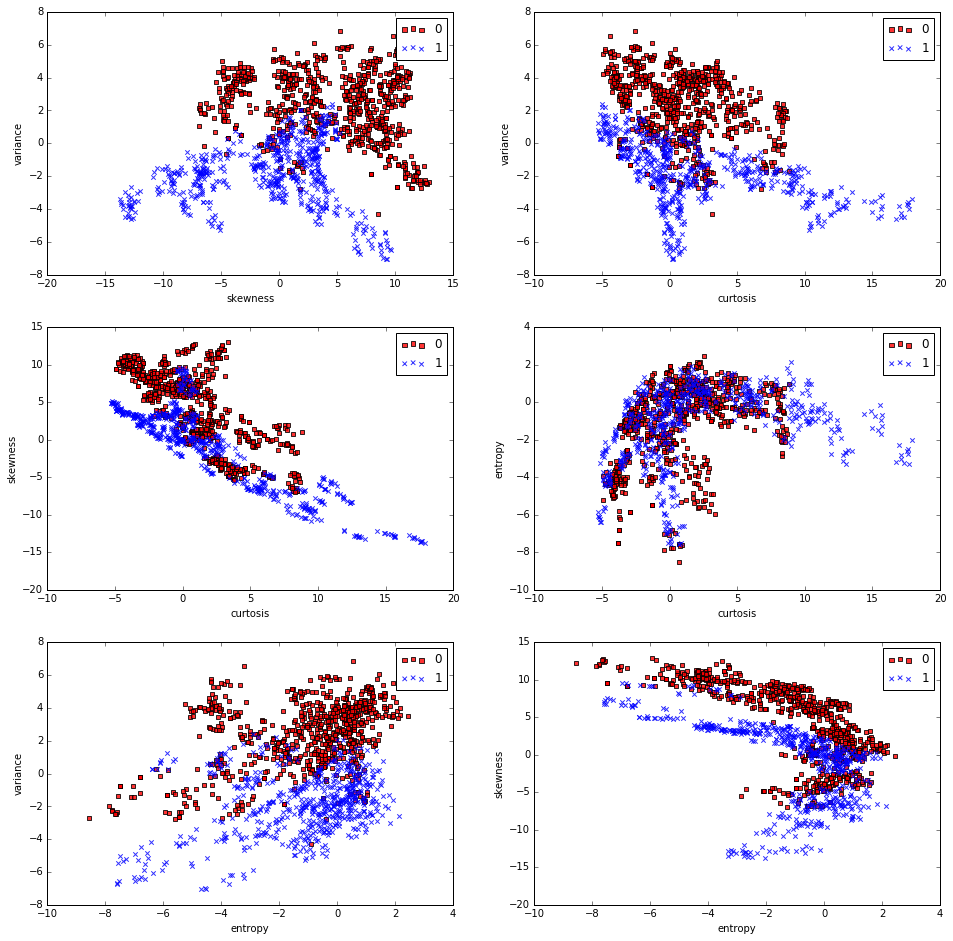

In [6]:
# setup marker generator and color map
from matplotlib.colors import ListedColormap
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y))])

def plot_all_samples(X, y, ax, labels=None):
    """2-dim scatter plot of class with respect to 2 features
    
    ----------
    parameters
    X - array of shape (n, 2) with features
    y - array of shape (n, 1) with class labels
    """
        
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)
        ax.legend(loc='best')
        
        if labels is not None:
            ax.set_xlabel(labels[0])
            ax.set_ylabel(labels[1])
        

fig, ax = plt.subplots(3, 2, figsize=(16, 16), sharex = False, sharey=False)

# plot all 6 feature pairs and sample classes
for idx,pair in enumerate(col_names_pairs):
    plot_all_samples(X[idx], y, fig.axes[idx], labels=pair) 
    


##### Before we apply the algorithm
It's important to plot various 2-dim class scatter plots in order to know which features discriminate forged / genuine. Also, it will be visible, then, how well the data are linearly seperable.

In [14]:
# TRAINING AND TEST SAMPLE SPLIT
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X[0], y, test_size=0.3, random_state=0)

In [15]:
# STANDARDISE THE FEATURE SPACE
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# X_train_std = X_train
# X_test_std = X_test

In [16]:
import warnings


def versiontuple(v):
    return tuple(map(int, (v.split("."))))


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')
        


In [17]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

def fit_and_evaluate_svm(svm, ax=None):
    """- Fits svm,
       - prints classifier accuracy obtained from k-fold cross validation
       - plots data and decision boundaries
       
       parameters
       svm - SVC classifier
    """

    if ax is None:
        ax = plt
        
    svm.fit(X_train_std, y_train)

    # below is more biased than cross val.
    # y_pred = svm.predict(X_test_std)
    # print "Accuracy: %.3f" % accuracy_score(y_test, y_pred)

    test_to = len(X_combined_std)
    test_from = test_to - len(X_test_std)

    plot_decision_regions(X_combined_std, y_combined,
                          classifier=svm, test_idx=range(test_from, test_to))
    ax.xlabel('skewness [standardized]')
    ax.ylabel('variance [standardized]')
    ax.legend(loc='upper left')
    ax.tight_layout()
    # plt.savefig('./plot.png', dpi=300)
    ax.show()

    scores = cross_validation.cross_val_score(svm, X_combined_std, y_combined, cv=5)

    # 2 sigma (95% confidence level) accuracy
    print("Accuracy: %0.2f (+/- %0.2f) (at 0.95 confidence level)" % (scores.mean(), scores.std() * 2))

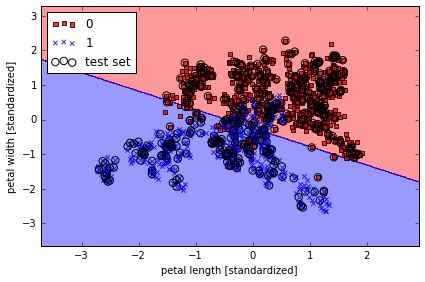

Accuracy: 0.88 (+/- 0.03) (at 0.95 confidence level)


In [19]:
svm = SVC(kernel='linear', C=.01, random_state=0)

fit_and_evaluate_svm(svm)

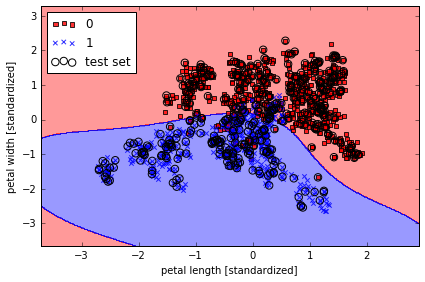

Accuracy: 0.92 (+/- 0.04) (at 0.95 confidence level)


In [20]:
# Gaussian kernel; small gamma
svm = SVC(kernel='rbf', random_state=0, gamma=0.2, C=1.0)
fit_and_evaluate_svm(svm)

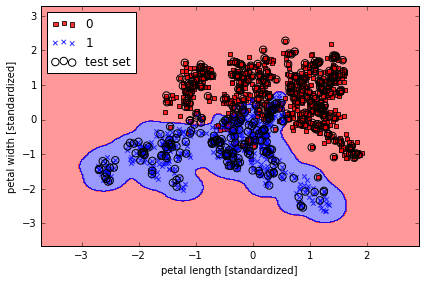

Accuracy: 0.93 (+/- 0.01) (at 0.95 confidence level)


In [21]:
# Gaussian kernel; big gamma
svm = SVC(kernel='rbf', random_state=0, gamma=20, C=1.0)
fit_and_evaluate_svm(svm)

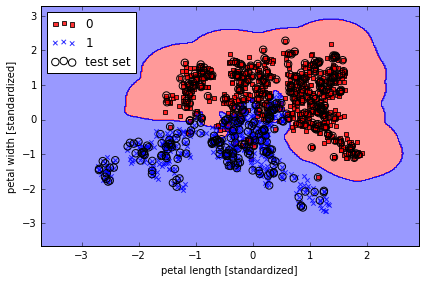

Accuracy: 0.94 (+/- 0.01) (at 0.95 confidence level)


In [22]:
# Gaussian kernel; big gamma, big C
svm = SVC(kernel='rbf', random_state=0, gamma=20, C=100.0)
fit_and_evaluate_svm(svm)

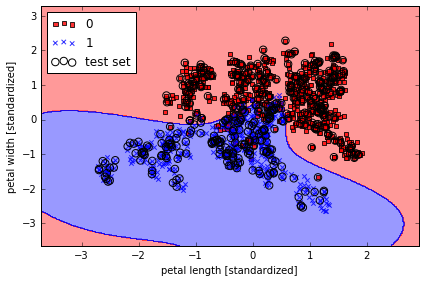

Accuracy: 0.93 (+/- 0.03) (at 0.95 confidence level)


In [23]:
# Gaussian kernel; small gamma, big C
svm = SVC(kernel='rbf', random_state=0, gamma=.2, C=100.0)
fit_and_evaluate_svm(svm)